In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math
from lineticks import LineTicks
import pandas as pd
import os

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# The data

As usual, let's start by reading some data. First we read the data for each shot.

In [3]:
shots = pd.read_csv('shots.csv', index_col=0)
shots.tail()

,config_id,weight_in_basket,split_weight,split_brix,notes
id,,,,,
116,12,18.28,45.13,11.2,Lots of change in flow rate
117,11,17.91,30.35,15.1,Used blind basket before this shot
118,11,18.02,30.66,15.0,NaN
119,11,18.14,11.41,26.9,Used blind basket before this shot
120,11,18.17,10.15,28.9,NaN


Each shot belongs to a configuration. The description for each configuration is located in a second file.

In [4]:
configs = pd.read_csv('configs.csv', index_col=0)
configs.tail()

,description
id,
8,"Hana Asrat Uraga (6.5 bar, no filter, grind 2...."
9,"Hana Asrat Uraga (6.5 bar, no filter, grind 2...."
10,"Rosso Decaf (6.5 bar, no filter, grind 1.50, 2..."
11,"Rosso Decaf (6.5 bar, Chemex, grind 1.50, 2 ta..."
12,"Rosso Decaf (6.5 bar, Whatman 5, grind 1.50, 2..."


Now we calculate brew ratio, EY, and TDS for each shot.

In [5]:
shots['tds'] = shots['split_brix'] / 100. * 0.85
shots['ey'] = shots['tds'] * shots['split_weight'] / shots['weight_in_basket']
shots['brew_ratio'] = shots['split_weight'] / shots['weight_in_basket']
shots.tail()

,config_id,weight_in_basket,split_weight,split_brix,notes,tds,ey,brew_ratio
id,,,,,,,,
116,12,18.28,45.13,11.2,Lots of change in flow rate,0.09520,0.235032,2.468818
117,11,17.91,30.35,15.1,Used blind basket before this shot,0.12835,0.217500,1.694584
118,11,18.02,30.66,15.0,NaN,0.12750,0.216934,1.701443
119,11,18.14,11.41,26.9,Used blind basket before this shot,0.22865,0.143820,0.628997
120,11,18.17,10.15,28.9,NaN,0.24565,0.137223,0.558613


# The model

Now we define the model.

In [6]:
def get_model_tds(br, m, tau):
    return m / br * (1 - np.exp(-br / tau))

Let's see what the plot of TDS vs. brew ratio for the model looks like.

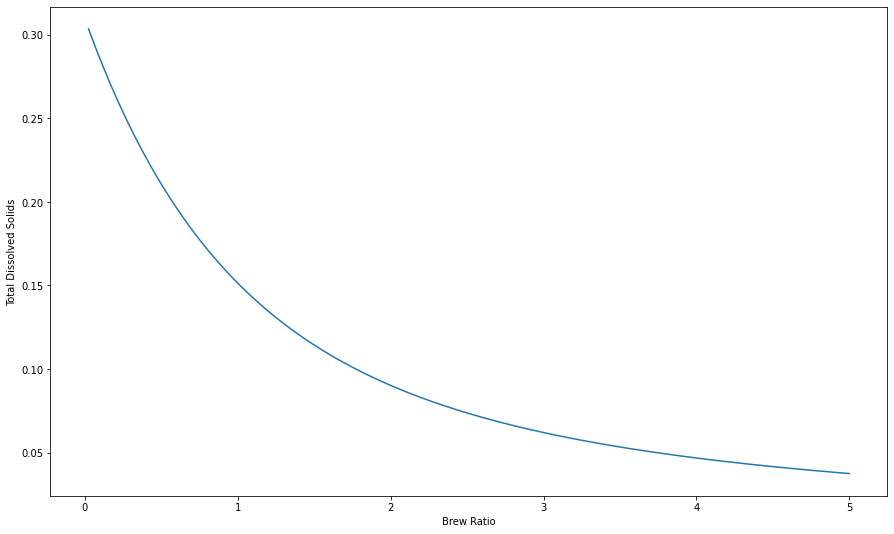

In [7]:
# Model parameters
model_m = 0.187268
model_tau = 0.604208

fig, ax = plt.subplots(figsize=(15,9))

ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Total Dissolved Solids')

xs = np.linspace(0., 5., 201)[1:]
ys = get_model_tds(xs, model_m, model_tau)

ax.plot(xs, ys)

# Get limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Measurement error

Next we calculate measurement error for each shot.

In [8]:
s_m = 0.05   # Error in weight measurements
s_brix = 0.2 # Error in Brix measurements

shots['s_tds'] = 0.0085 * s_brix
shots['s_br'] = s_m / shots['weight_in_basket'] * np.sqrt(1 + (shots['brew_ratio'])**2)
shots.tail()

,config_id,weight_in_basket,split_weight,split_brix,notes,tds,ey,brew_ratio,s_tds,s_br
id,,,,,,,,,,
116,12,18.28,45.13,11.2,Lots of change in flow rate,0.09520,0.235032,2.468818,0.0017,0.007286
117,11,17.91,30.35,15.1,Used blind basket before this shot,0.12835,0.217500,1.694584,0.0017,0.005493
118,11,18.02,30.66,15.0,NaN,0.12750,0.216934,1.701443,0.0017,0.005476
119,11,18.14,11.41,26.9,Used blind basket before this shot,0.22865,0.143820,0.628997,0.0017,0.003256
120,11,18.17,10.15,28.9,NaN,0.24565,0.137223,0.558613,0.0017,0.003152


# Maximum likelihood

Next, we're going to fit the model to our data by maximizing the likelihood of the data given a particular set of model parameters. For illustration purposes, we'll use a single configuration from our data set.

In [9]:
# Get shots for one configuration
some_shots = shots[shots['config_id'] == 1]

# Experimental measurements and errors
expt_br = some_shots['brew_ratio'].values
expt_tds = some_shots['tds'].values
sigma_br = some_shots['s_br'].values
sigma_tds = some_shots['s_tds'].values
config_id = some_shots['config_id'].values - 1

Now we'll define the probability distribution for a single measurement. The plot below shows the sum of these probability distributions for visualization purposes only.

(0.024135509927652267, 0.316923597099536)

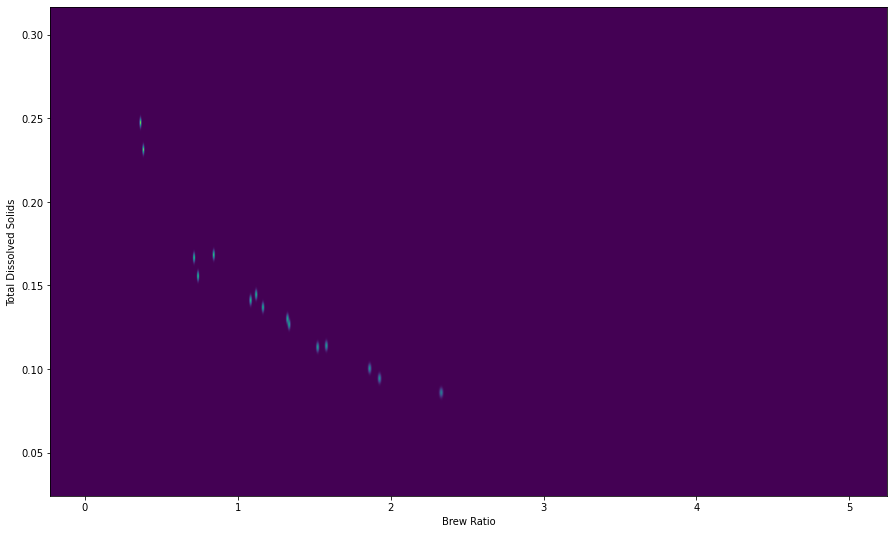

In [10]:
def get_pdf(X, Y, br, tds, s_br, s_tds):
    return norm.pdf(X, br, s_br) * norm.pdf(Y, tds, s_tds)

xs = np.linspace(xlim[0], xlim[1], 1500)
ys = np.linspace(ylim[0], ylim[1], 900)

X, Y = np.meshgrid(xs, ys)
Z = np.zeros(X.shape)
for br_i, tds_i, s_br_i, s_tds_i in zip(expt_br, expt_tds, sigma_br, sigma_tds):
    Z += get_pdf(X, Y, br_i, tds_i, s_br_i, s_tds_i)

fig, ax = plt.subplots(figsize=(15,9))

ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Total Dissolved Solids')

ax.imshow(Z, aspect='auto', extent=(xlim[0], xlim[1], ylim[1], ylim[0]))

# Set limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

Next, we integrate the individual distributions along the model curve to get the individual likelihood for that curve.

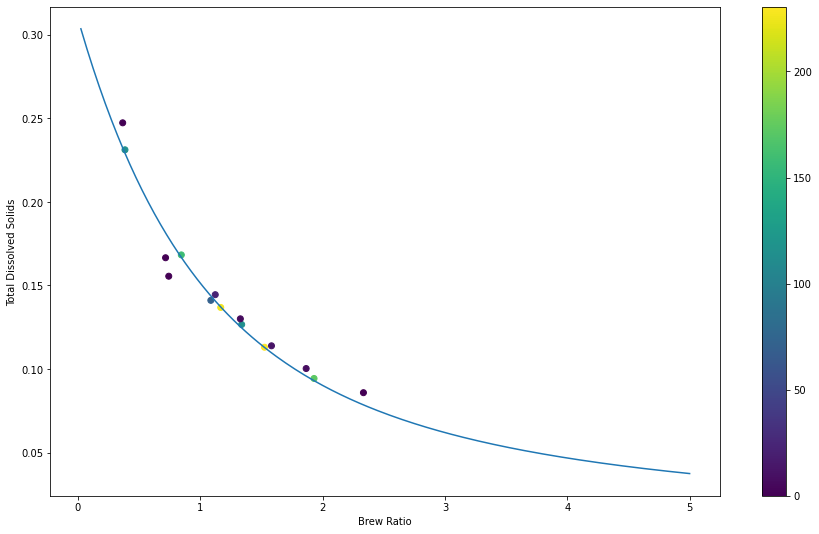

In [11]:
def single_likelihood(theta, br, tds, s_br, s_tds, cfg_id_i):
    m, tau = theta[2*cfg_id_i:2*(cfg_id_i+1)]
    s_p = theta[-1]
    xs = np.linspace(br - s_br * 10., br + s_br * 10., 201)
    ys = get_model_tds(xs, m, tau)
    zs = get_pdf(xs, ys, br, tds, s_br, np.sqrt(s_tds**2 + s_p**2))
    zs = (zs[:-1] + zs[1:]) / 2.
    return sum(zs) * (xs[1] - xs[0])

# Get likelihoods
theta = model_m, model_tau, 0.
likelihoods = [single_likelihood(theta, br_i, tds_i, s_br_i, s_tds_i, cfg_id_i) 
               for br_i, tds_i, s_br_i, s_tds_i, cfg_id_i in zip(expt_br, expt_tds, sigma_br, sigma_tds, config_id)]

# Plot model
fig, ax = plt.subplots(figsize=(15,9))

ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Total Dissolved Solids')

xs = np.linspace(0., 5., 201)[1:]
ys = get_model_tds(xs, model_m, model_tau)
ax.plot(xs, ys)

# Plot data
sc = ax.scatter(expt_br, expt_tds, c=likelihoods)
plt.colorbar(sc)

To get the likelihood for a set of measurements, we multiply the likelihoods for the individual measurements. Equivalently, we can get the log-likelihood for the set of measurements by adding up the log-likelihoods of the individual measurements.

In [12]:
def log_likelihood(theta, br, tds, s_br, s_tds, cfg_id):
    likelihoods = [single_likelihood(theta, br_i, tds_i, s_br_i, s_tds_i, cfg_id_i) 
                   for br_i, tds_i, s_br_i, s_tds_i, cfg_id_i in zip(br, tds, s_br, s_tds, cfg_id)]
    if np.all(np.array(likelihoods) > 0):
        return sum(np.log(likelihoods))
    else:
        return -np.inf

Now we can maximize likelihood to find the best fit curve for each configuration.

In [13]:
nll = lambda *args: -log_likelihood(*args)

# Experimental measurements and errors
expt_br = np.array(shots['brew_ratio'])
expt_tds = np.array(shots['tds'])
sigma_br = np.array(shots['s_br'])
sigma_tds = np.array(shots['s_tds'])
config_id = np.array(shots['config_id']) - 1

# Initial values
N = len(configs)
initial = np.array([1., 1.] * N + [0.])
bounds = [(0., 1.), (0., None)] * N + [(0., None)]

# We need to ease into the optimization
for r in np.logspace(2., 0., num=12):
    soln = minimize(nll, initial, args=(expt_br, expt_tds, r * sigma_br, r * sigma_tds, config_id), bounds=bounds)
    initial = soln.x

soln

c:\python39\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -437.20463536824764
 hess_inv: <25x25 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.05526317, -0.02783054, -0.12710188,  0.02077059,  0.05568381,
       -0.11524435, -0.08315624,  0.01226681, -0.00314913,  0.0299508 ,
       -0.14929356,  0.06291998, -0.27088731,  0.15108412, -0.23368898,
        0.14139232, -0.17841444, -0.01111857, -0.30233878,  0.14226202,
       -0.04759499, -0.04013145, -0.20493189, -0.0219643 ,  0.16807462])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 286
      nit: 5
     njev: 11
   status: 0
  success: True
        x: array([0.1872528 , 0.60410061, 0.20413966, 0.79741028, 0.26351858,
       1.00998558, 0.21221934, 0.67765003, 0.21194337, 0.75256609,
       0.22421589, 0.77314473, 0.20671788, 0.62339422, 0.21503476,
       0.66996513, 0.23660292, 0.82003623, 0.21355848, 0.6321372 ,
       0.22839159, 0.63377747, 0.26455295, 0.86628877, 0.00530457])

Let's save these model parameters.

In [14]:
fit_theta = soln.x

# Markov chain Monte Carlo

Now we set up Markov chain Monte Carlo. First we define the priod and posterior.

In [15]:
def log_prior(theta):
    m_i = theta[:-1:2]
    tau_i = theta[1:-1:2]
    s_p = theta[-1]
    
    if np.all(m_i >= 0) and np.all(m_i <= 1) and np.all(tau_i >= 0) and s_p >= 0:
        return np.sum(-np.log(tau_i)) - np.log(s_p)
    else:
        return -np.inf

def log_posterior(theta, br, tds, s_br, s_tds, cfg_id):
    lp = log_prior(theta)
    ll = log_likelihood(theta, br, tds, s_br, s_tds, cfg_id)
    if np.isfinite(lp) and np.isfinite(ll) :
        return lp + ll
    else:
        return -np.inf

Then we set up the computation.

In [16]:
ndim = 2 * N + 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 500  # "burn-in" period to let chains stabilize
nthin = 25 # thin by about half the autocorrelation time
nsteps = 5000  # number of MCMC steps to take

And finally we sample the distribution using emcee.

In [17]:
# Get filename for cached data
filename = 'emcee/all_configs.csv'

if os.path.exists(filename):
    # Load samples from cache
    flat_samples = np.loadtxt(filename, delimiter=',')
else:
    # Iniitalize the walkers
    np.random.seed(42)
    starting_guesses = fit_theta + ([1e-4, 1e-4] * N + [1e-6]) * np.random.randn(nwalkers, ndim)

    # Run sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                    args=[expt_br, expt_tds, sigma_br, sigma_tds, config_id])
    sampler.run_mcmc(starting_guesses, nsteps, progress=True)

    # Display autocorrelation time
    sampler.get_autocorr_time(quiet=True)
    
    # Save samples
    flat_samples = sampler.get_chain(discard=nburn, thin=nthin, flat=True)
    np.savetxt(filename, flat_samples, delimiter=',')

 28%|████████████████████▍                                                     | 1383/5000 [2:01:12<9:02:32,  9.00s/it]<ipython-input-6-dca42ed8babd>:2: RuntimeWarning: overflow encountered in exp
  return m / br * (1 - np.exp(-br / tau))
100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [7:23:52<00:00,  5.33s/it]
The chain is shorter than 50 times the integrated autocorrelation time for 25 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [234.88195454 247.3149545  232.57674004 231.14018267 269.41041774
 266.23303037 266.34175829 266.97951122 231.10291518 222.71525571
 254.377907   250.29837627 237.10790649 225.94695353 236.99825403
 234.20514905 231.23480461 223.87876293 236.68639767 234.10298399
 272.54302873 272.01712431 270.16161081 265.54853064 262.01649435]


What does the corner plot look like?

1: Margarito Herrera (9.0 bar, no filter, grind 2.25, 2 tamps at 15 lb)
2: Two Wheel (9.0 bar, no filter, grind 1.50, 2 tamps)
3: Two Wheel (9.0 bar, Whatman 5, grind 1.50, 2 tamps)
4: Two Wheel (6.5 bar, no filter, grind 1.50, 2 tamps)
5: Two Wheel (6.5 bar, no filter, grind 1.30, 2 tamps)
6: Hana Asrat Uraga (6.5 bar, no filter, grind 2.00, 2 tamps)
7: Hana Asrat Uraga (6.5 bar, no filter, grind 2.20, 2 tamps)
8: Hana Asrat Uraga (6.5 bar, no filter, grind 2.20, 2 tamps)
9: Hana Asrat Uraga (6.5 bar, no filter, grind 2.20, 10 tamps)
10: Rosso Decaf (6.5 bar, no filter, grind 1.50, 2 tamps)
11: Rosso Decaf (6.5 bar, Chemex, grind 1.50, 2 tamps)
12: Rosso Decaf (6.5 bar, Whatman 5, grind 1.50, 2 tamps)


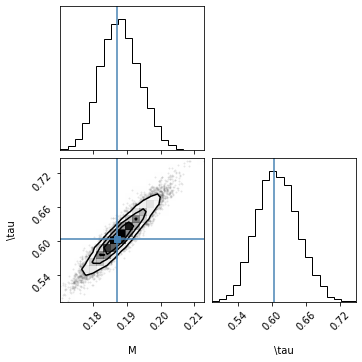

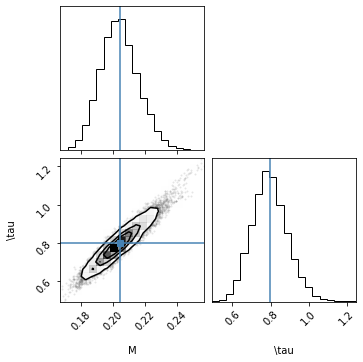

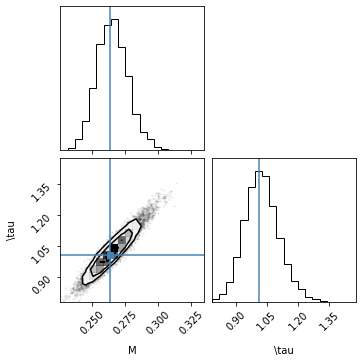

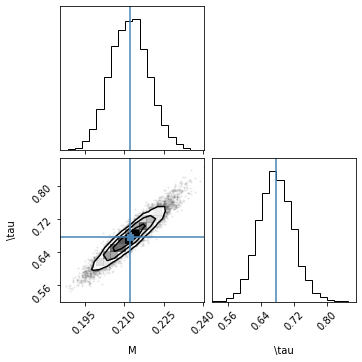

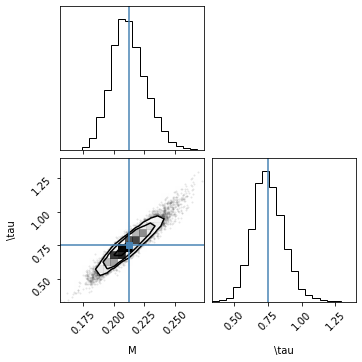

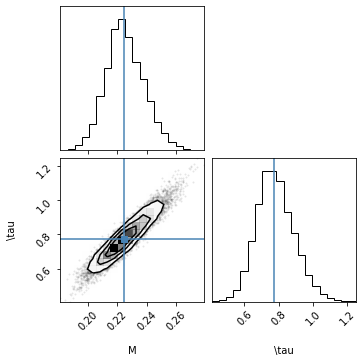

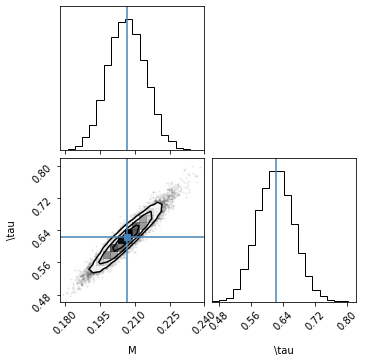

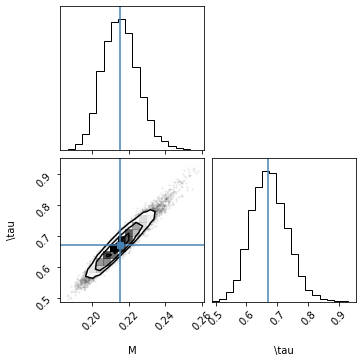

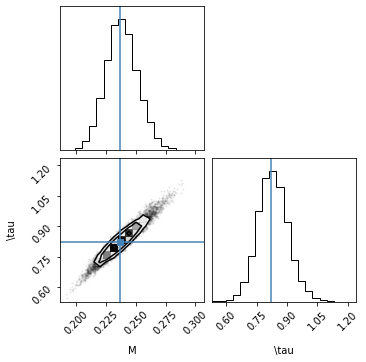

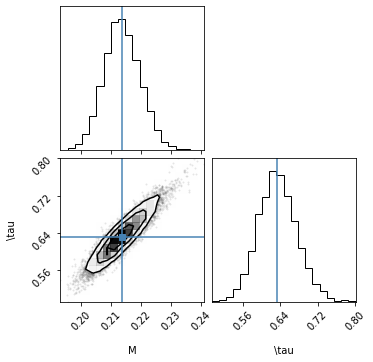

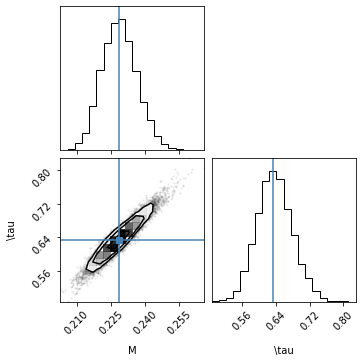

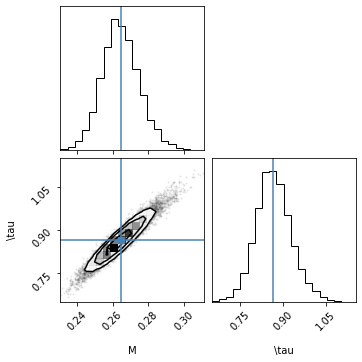

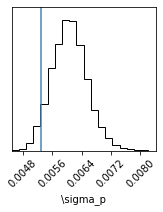

In [18]:
labels = ['M', '\\tau', '\\sigma_p']

for index, row in configs.iterrows():
    k = index - 1
    fs = flat_samples[:, [2 * k, 2 * k + 1]]

    fit_m = fit_theta[2 * k]
    fit_tau = fit_theta[2 * k + 1]
    
    fig = corner.corner(
        fs, labels=labels[:2], truths=[fit_m, fit_tau]
    )

    fig.suptitle(print(f'{index}: ' + row['description']))

fig = corner.corner(
    flat_samples[:, -1], labels=[labels[-1]], truths=[fit_theta[-1]]
)

Now we can get the model parameters with uncertainty. Here, we calculate the 68% credible interval for each model parameter.

In [19]:
txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"

for index, row in configs.iterrows():
    print(f'{index}: ' + row['description'] + '...')

    k = index - 1
    fs = flat_samples[:, [2 * k, 2 * k + 1]]

    for i in range(2):
        mcmc = np.percentile(fs[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        display(Math(txt.format(mcmc[1], q[0], q[1], labels[i])))

print('All samples...')

mcmc = np.percentile(flat_samples[:, -1], [16, 50, 84])
q = np.diff(mcmc)
display(Math(txt.format(mcmc[1], q[0], q[1], labels[2])))

1: Margarito Herrera (9.0 bar, no filter, grind 2.25, 2 tamps at 15 lb)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

2: Two Wheel (9.0 bar, no filter, grind 1.50, 2 tamps)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

3: Two Wheel (9.0 bar, Whatman 5, grind 1.50, 2 tamps)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

4: Two Wheel (6.5 bar, no filter, grind 1.50, 2 tamps)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

5: Two Wheel (6.5 bar, no filter, grind 1.30, 2 tamps)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

6: Hana Asrat Uraga (6.5 bar, no filter, grind 2.00, 2 tamps)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

7: Hana Asrat Uraga (6.5 bar, no filter, grind 2.20, 2 tamps)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

8: Hana Asrat Uraga (6.5 bar, no filter, grind 2.20, 2 tamps)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

9: Hana Asrat Uraga (6.5 bar, no filter, grind 2.20, 10 tamps)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

10: Rosso Decaf (6.5 bar, no filter, grind 1.50, 2 tamps)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

11: Rosso Decaf (6.5 bar, Chemex, grind 1.50, 2 tamps)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

12: Rosso Decaf (6.5 bar, Whatman 5, grind 1.50, 2 tamps)...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

All samples...


<IPython.core.display.Math object>

Finally, let's plot it all.

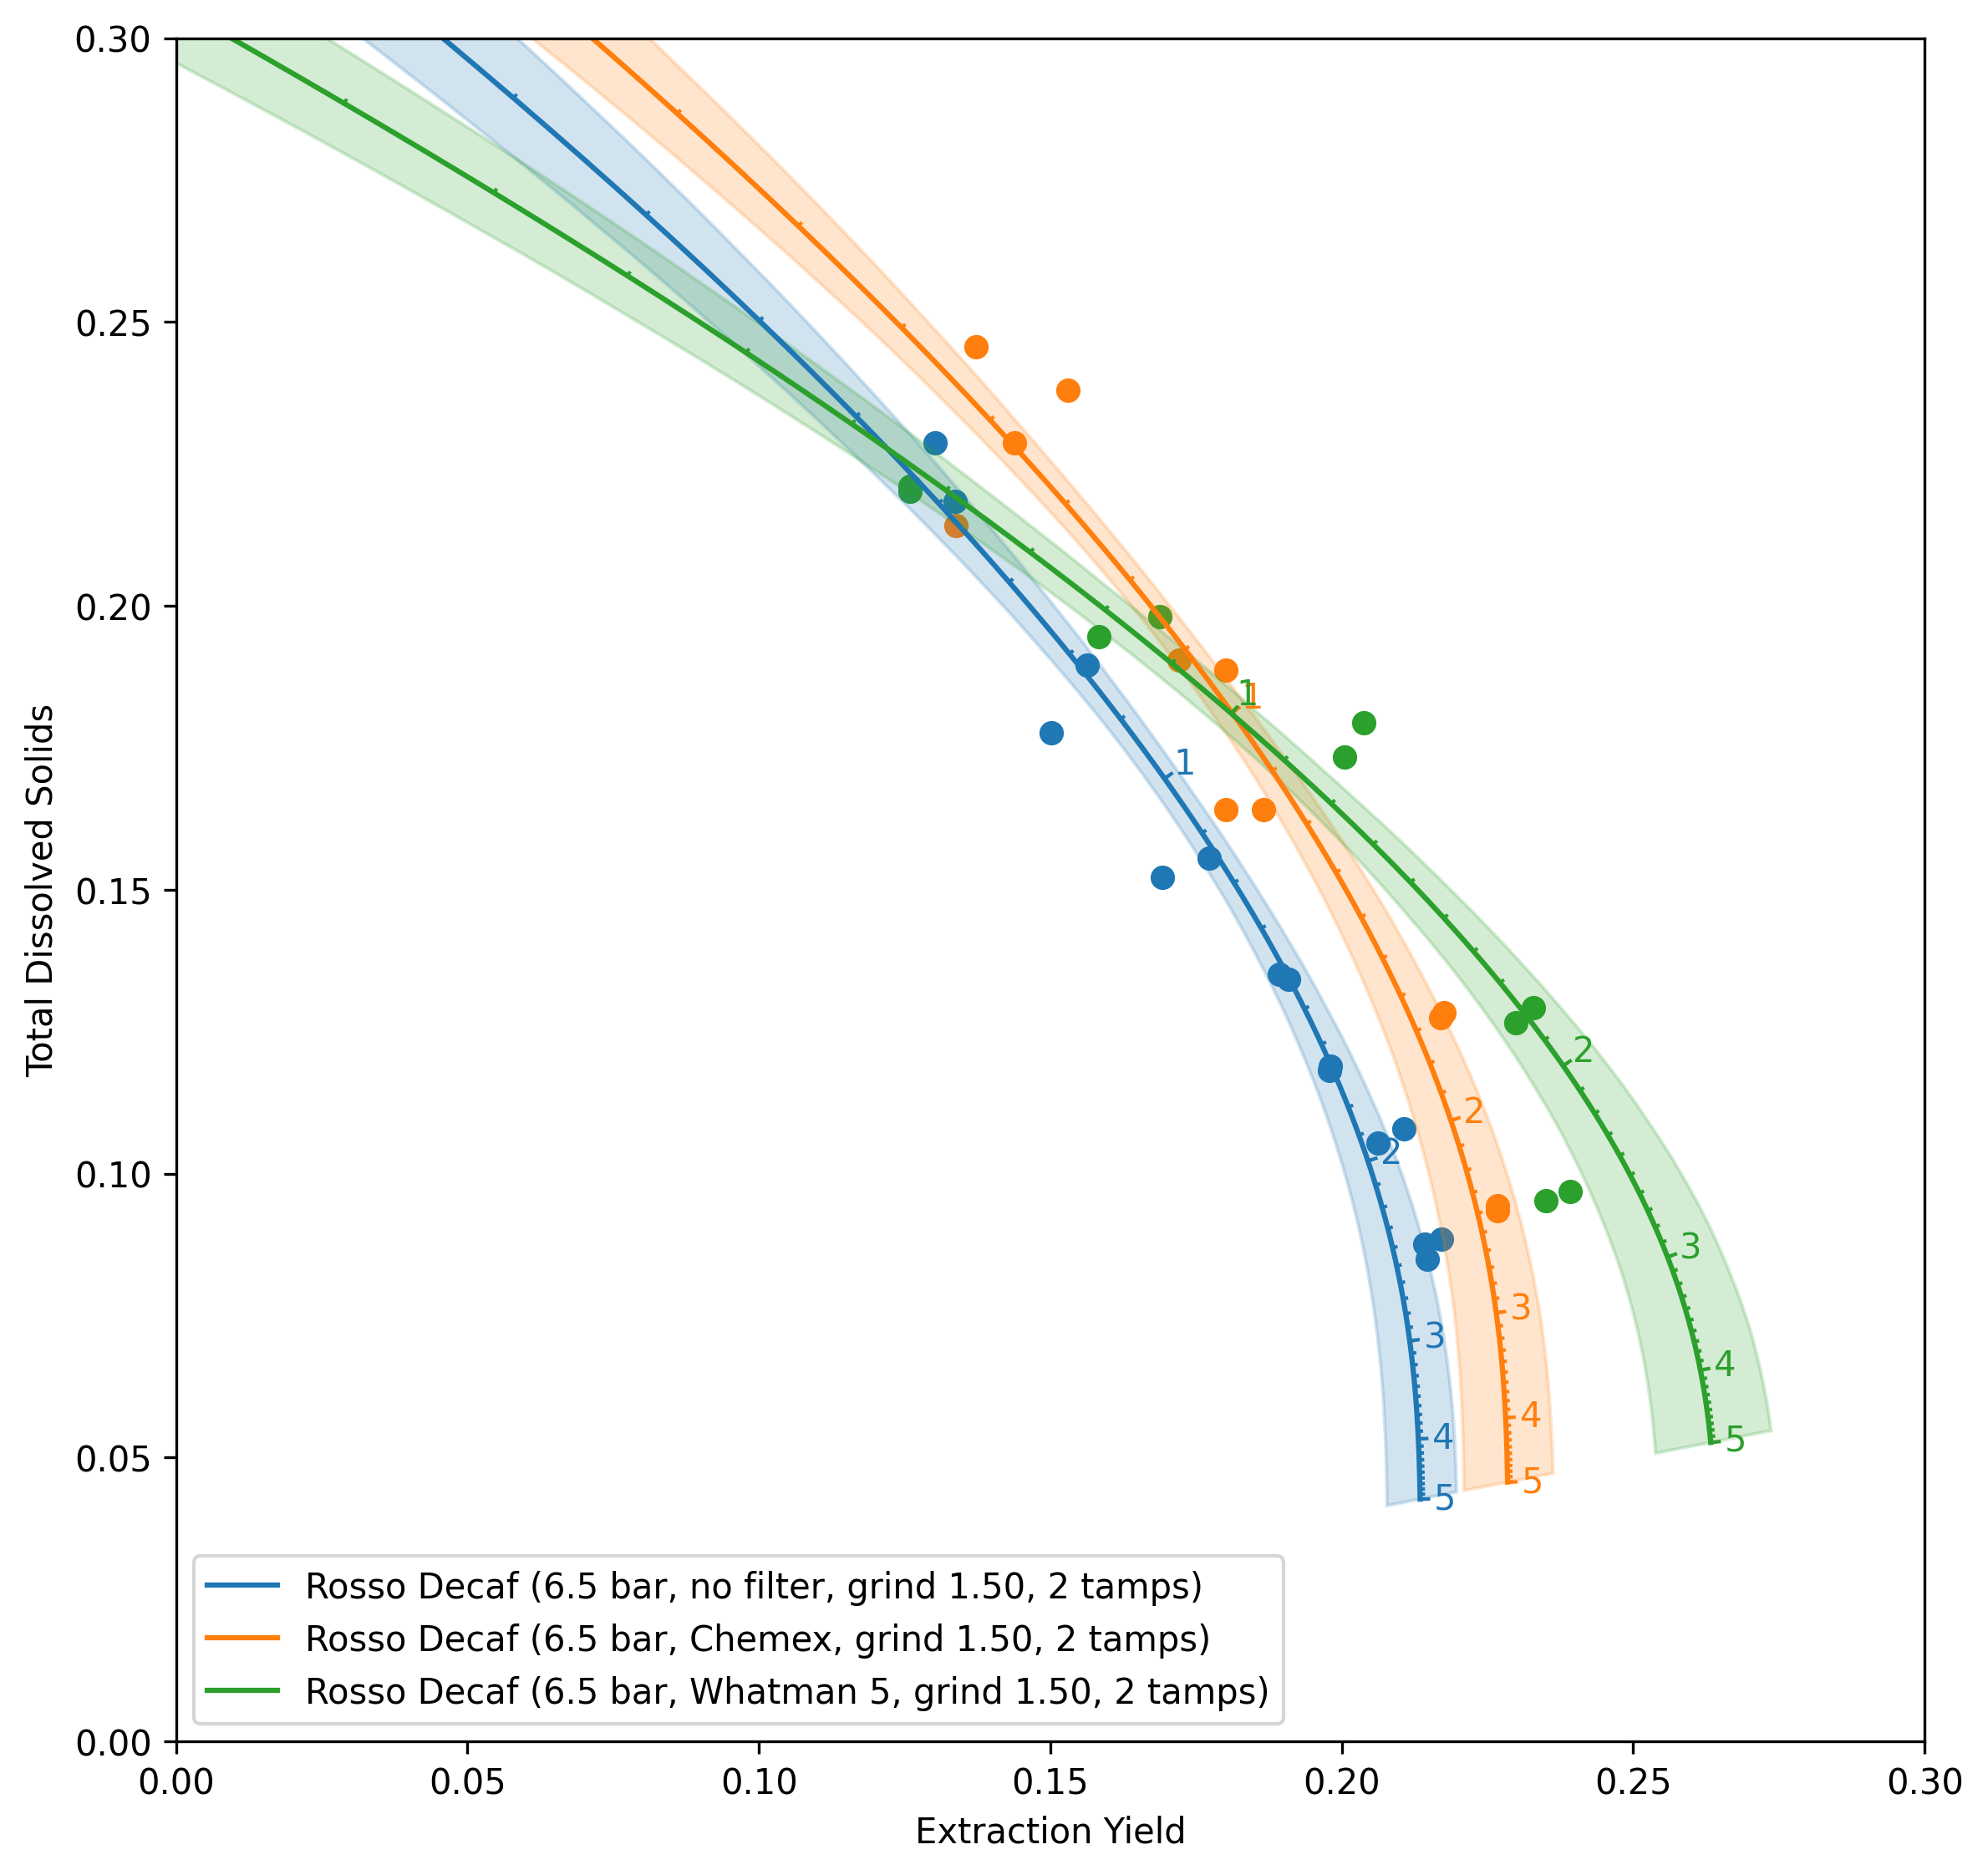

In [20]:
plot_br = ('Brew Ratio', lambda br, tds: br)
plot_tds = ('Total Dissolved Solids', lambda br, tds: tds)
plot_ey = ('Extraction Yield', lambda br, tds: br * tds)

def plot_fit(ax, fx, fy, br, m, tau, color=None, label=None):
    tds = get_model_tds(br, m, tau)
    
    # Draw maximum likelihood curve
    traj, = ax.plot(fx[1](br, tds), fy[1](br, tds), color=color, label=label)

    if fx != plot_br and fy != plot_br:
        # Draw ticks to indicate brew ratio
        major_ticks = LineTicks(traj, range(0, 201, 40), 10, lw=1, 
                                label=['{:.0f}'.format(round(tt)) for tt in br[::40]])
        minor_ticks = LineTicks(traj, range(0, 201, 4), 4, lw=1)

def plot_points(ax, fx, fy, some_shots, color=None):
    br = np.array(some_shots['brew_ratio'])
    tds = np.array(some_shots['tds'])
    
    # Draw data points
    ax.scatter(fx[1](br, tds), fy[1](br, tds), color=color)
    
def plot_labels(ax, fx, fy):
    ax.set_xlabel(fx[0])
    ax.set_ylabel(fy[0])

def plot_credible_interval(ax, fx, fy, br, samples, color=None):
    m, tau, s_p = samples.T

    tds = get_model_tds(br, m[:, None], tau[:, None])
    tds_lower, tds_upper = np.percentile(tds, [16, 84], axis=0)

    # Plot 95% credible interval
    plt.fill(np.append(fx[1](br, tds_upper), fx[1](br[::-1], tds_lower[::-1])), 
             np.append(fy[1](br, tds_upper), fy[1](br[::-1], tds_lower[::-1])), 
             color=color, alpha=0.2)

fig, ax = plt.subplots(figsize=(9,9), dpi=300)
fig.patch.set_facecolor('white')

plot_x = plot_ey
plot_y = plot_tds

lim_br = (0., 3.)
lim_tds = (0., 0.30)
lim_ey = (0., 0.30)

plot_labels(ax, plot_x, plot_y)

plt.xlim(lim_ey)
plt.ylim(lim_tds)

# Select some configuraitons
some_configs = configs[configs.index.isin([10,11,12])]

for ci, (index, row) in enumerate(some_configs.iterrows()):
    some_shots = shots[shots['config_id'] == index]

    # Get flat samples this shot
    k = index - 1
    fs = flat_samples[:, [2 * k, 2 * k + 1, -1]]
    
    # Get best fit parameters
    fit_m = np.percentile(fs[:, 0], 50)
    fit_tau = np.percentile(fs[:, 1], 50)

    # Get plot colour
    color = f'C{ci}'

    # Plot maximum likelihood fit
    plot_fit(ax, plot_x, plot_y, 
             np.append([1e-6], np.linspace(0., 5., 201)[1:]), 
             fit_m, fit_tau, 
             color, row['description'])

    # Plot points
    plot_points(ax, plot_x, plot_y, some_shots, color)

    # Plot 95% credible interval
    plot_credible_interval(ax, plot_x, plot_y, 
                           np.append([1e-6], np.linspace(0., 5., 201)[1:]), 
                           fs, color)

    # Plot m and tau
    if plot_x == plot_br and plot_y == plot_ey:
        plt.axvline(x=fit_tau, c=color, linestyle='--')
        plt.axhline(y=fit_m, c=color, linestyle='--')

ax.legend()